
# Predicting the Price of Used Cars Using Machine Learning Algorithms
<font color = 'Blue'> 
Names: Shin Le, Jeongyeon Kim, Benjamin Horvath, Nico Reategui, Paul Giglio


Proposal: https://docs.google.com/document/d/1zhQrkWmJjjMU6wIfBC78MygGzp-XUrkaUOWALfyAL9Q/edit

Dataset: 
* https://www.kaggle.com/datasets/wspirat/germany-used-cars-dataset-2023/data
    
* https://www.kaggle.com/datasets/andreinovikov/used-cars-dataset

<a id="0"></a> <br>
<font color = 'Blue'> 
# Table of Contents

1. [About Dataset](#1)
1. [Importing Libraries](#2)
1. [Functions Implementation](#3)
1. [Loading Data](#4)
1. [Data Preprocessing](#5)
1. [Exploratory Data Analysis (EDA)](#6)
1. [Data Splitting](#7)
1. [Models Evaluations and Predictions](#8)
   1. [*Full Model* with *Linear Regression*](#81)
   1. [Using Sequential Feature Selection for the *Linear Regression*](#82)
   1. [*Decision Tree*](#83)
   1. [*A Pruned Tree*](#84)
   1. [Ensemble Method: *Random Forest Regression*](#85)
   1. [Ensemble Method: *Gradient Boosting Regression*](#86)
   1. [*Support Vector Machine* (SVM)](#87)


<a id="1"></a>
<font color = 'blue'> 
## **1. About Dataset**

<a id="2"></a>
<font color = 'blue'> 
## **2. Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # Corrected import
%matplotlib inline  # Ensures that Matplotlib plots are displayed inline

import statsmodels.api as sm


#preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder 




UsageError: unrecognized arguments: # Ensures that Matplotlib plots are displayed inline


<a id="3"></a>
<font color = 'blue'> 
## **3. Functions Implementation**


<a id="4"></a>
<font color = 'blue'> 
## **4. Loading Data**

<div class="alert alert-block alert-warning">
<b>Note:</b>

You have to update the link if there is an error when you load data. 

* Open **Github** -> Open the dataset - **germanycars.csv** --> Click "**View Raw**" --> **Copy the link**

You must save before you are able to **Commit & Push** 
* You can go to **File --> Auto Save**
</div>


In [2]:
'''
# Define the URL of the CSV file on GitHub
csv_url = "https://raw.githubusercontent.com/syl21b/Car-Price-Prediction/main/germanycars.csv?token=GHSAT0AAAAAACIQMGDUI2ZHP5YRJCPW4ZVKZJ37DUA"

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_url)

# Now you have the data in the 'df' DataFrame'''

'\n# Define the URL of the CSV file on GitHub\ncsv_url = "https://raw.githubusercontent.com/syl21b/Car-Price-Prediction/main/germanycars.csv?token=GHSAT0AAAAAACIQMGDUI2ZHP5YRJCPW4ZVKZJ37DUA"\n\n# Read the CSV file into a DataFrame\ndf = pd.read_csv(csv_url)\n\n# Now you have the data in the \'df\' DataFrame'

In [3]:
import requests
import zipfile
import io
import os
import pandas as pd
from os.path import expanduser

# URL of the ZIP file
url = "https://github.com/syl21b/Car-Price-Prediction/raw/main/cars.csv.zip"

# Directory to save extracted files in your home directory
output_directory = os.path.join(expanduser("~"), "car_data")

# Ensure the output directory exists or create it if not
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Send a GET request to the URL
response = requests.get(url)

if response.status_code == 200:
    # Create a BytesIO object to work with the content
    zip_data = io.BytesIO(response.content)

    # Create a ZipFile object to extract the contents
    with zipfile.ZipFile(zip_data, 'r') as zip_ref:
        # Extract all files from the ZIP archive to the output directory
        zip_ref.extractall(output_directory)

    print("ZIP file has been successfully downloaded and extracted to the specified directory.")
else:
    print(f"Failed to download ZIP file. Status code: {response.status_code}")

# Load the CSV file into a DataFrame
csv_file_path = os.path.join(output_directory, "cars.csv")
df = pd.read_csv(csv_file_path)

# Now you can work with the 'df' DataFrame


ZIP file has been successfully downloaded and extracted to the specified directory.


<a id="5"></a>
<font color = 'blue'> 
## **5. Data Preprocessing**

In [4]:
# Sample data
df = pd.DataFrame(df)

# Use str.extract to create new columns
df[['Engine Displacement (L)', 'Engine Type', 'Engine Features']] = df['engine'].str.extract(r'(\d+\.\d+)L\s([A-Z0-9]+)\s(.+)$')

# Drop the original 'engine' column if you no longer need it
df = df.drop(columns=['engine'])

# Print the DataFrame
df

,manufacturer,model,year,mileage,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,...,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price,Engine Displacement (L),Engine Type,Engine Features
0,Mazda,CX-90 3.3 Turbo Premium Plus,2024,1.0,8-Speed Automatic,All-wheel Drive,Gasoline,NaN,51K,White,...,1.0,Cox Mazda,3.2,NaN,0,NaN,54920,3.3,I6,Turbo
1,Mazda,CX-90 S Premium Plus,2024,1.0,8-Speed Automatic,All-wheel Drive,Gasoline,NaN,Artisan Red Metallic,White,...,1.0,Cox Mazda,3.2,NaN,0,NaN,61920,NaN,NaN,NaN
2,Acura,Integra A-Spec,2023,6.0,Automatic CVT,Front-wheel Drive,Gasoline,29-36,Red,Ebony,...,0.0,Glenview Luxury Imports,4.9,4.6,5,NaN,37434,1.5,I4,16V GDI DOHC Turbo
3,Acura,Integra A-Spec Technology,2023,9705.0,Automatic CVT,Front-wheel Drive,Gasoline,29-36,Platinum White Pearl,Ebony,...,1.0,Lindsay Acura,3.6,4.6,5,484.0,34516,1.5,I4,16V GDI DOHC Turbo
4,Acura,Integra A-Spec Technology,2023,6.0,Automatic CVT,Front-wheel Drive,Gasoline,29-36,Performance,Orchid,...,1.0,Plaza Auto Mall,4.0,4.6,5,674.0,33221,1.5,I4,16V GDI DOHC Turbo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758030,Toyota,Supra Turbo,1995,15800.0,6-Speed Manual,NaN,Gasoline,17-23,Black,Tan,...,1.0,Motorcar Classics,3.7,4.9,7,10000.0,89900,3.0,I6,24V SPFI DOHC Turbo
758031,Toyota,Supra Turbo,1995,44614.0,6-Speed Manual,Rear-wheel Drive,Gasoline,NaN,Silver,Black,...,1.0,Gold Coast Motors,NaN,4.9,7,6000.0,109900,3.0,I6,Turbo
758032,Volkswagen,Eurovan,1995,91849.0,Manual,Front-wheel Drive,Gasoline,NaN,White,Gray,...,1.0,Pacific Auto Center - Fontana,3.1,4.8,3,1000.0,31995,NaN,NaN,NaN
758033,Volkswagen,Eurovan Campmobile,1995,190336.0,5-Speed Manual,Front-wheel Drive,Gasoline,NaN,White,Gray,...,1.0,Lot 99,1.4,4.8,3,1000.0,25995,5.2,I5,10V SOHC


#before handling data

In [5]:
for feature in df.columns.tolist():
    print(f"{df[feature].value_counts()}, \n")

Ford             78680
Toyota           59393
Chevrolet        54828
Nissan           48482
Jeep             41543
Mercedes-Benz    40582
Honda            37601
BMW              37509
Kia              35063
GMC              29507
Dodge            25102
Subaru           24762
Volkswagen       24485
Hyundai          22203
Lexus            21292
RAM              19364
Audi             17863
Cadillac         17614
Mazda            15431
Buick            14509
Chrysler         12609
INFINITI         12287
Land Rover       12139
Porsche          11214
Lincoln          10518
Volvo            10022
Acura             8468
Tesla             5883
Mitsubishi        5737
Jaguar            3345
Name: manufacturer, dtype: int64, 

Fusion SE                                3172
Sportage LX                              2873
Corolla LE                               2835
GLC 300 Base 4MATIC                      2718
Sentra SV                                2652
                                         ...

### Filtering data


#### Mapping from long form to abbreviation
* Drivetrain

In [6]:

df = pd.DataFrame(df)

# Create a mapping from long form to abbreviation
drivetrain_mapping = {
    'All-wheel Drive': 'AWD',
    'Front-wheel Drive': 'FWD',
    'Four-wheel Drive': '4WD',
    'Rear-wheel Drive': 'RWD'
}

# Use the replace method to update the drivetrain column
df['drivetrain'] = df['drivetrain'].replace(drivetrain_mapping)


* fuel_type

In [7]:
df = pd.DataFrame(df)
# Create a dictionary for mapping
drivetrain_mapping = {
    'Gasoline Fuel': 'Gasoline',
    'Gas': 'Gasoline',
    'Plug-In Hybrid': 'Hybrid',
    'Hybrid Fuel': 'Hybrid',
    'Gas/Electric Hybrid': 'Hybrid',
    'Gasoline/Mild Electric Hybrid': 'Hybrid',
    'Diesel Fuel': 'Diesel',
    'Rear-wheel Drive': 'Electric',
    'E85 Flex Fuel': 'Flex Fuel',
    'Flex Fuel Capability': 'Flex Fuel'
}

# Use the replace method to update the drivetrain column
df['fuel_type'] = df['fuel_type'].replace(drivetrain_mapping)


#### Splitting `MPG` column into two separate columns

In [8]:
df['mpg'].fillna('0-0', inplace=True)



In [9]:
# Split the "MPG Range" into two columns
#df[['City MPG', 'Highway MPG']] = df['mpg'].str.split('-', expand=True).astype(int)
df[['City MPG', 'Highway MPG']] = df['mpg'].str.split('-', expand=True)

In [10]:
# Custom function to convert elements to int or replace with zero
def convert_to_int_or_zero(value):
    if isinstance(value, str):
        # Remove non-numeric characters and try to convert to int
        numeric_value = ''.join(filter(str.isdigit, value))
        if numeric_value:
            return int(numeric_value)
    return 0

# Apply the custom function to 'City MPG' and 'Highway MPG' columns
df['City MPG'] = df['City MPG'].apply(convert_to_int_or_zero)
df['Highway MPG'] = df['Highway MPG'].apply(convert_to_int_or_zero)


In [11]:
# Replace "N/A" values with NaN
df['City MPG'] .replace(0, np.nan, inplace=True)
df['Highway MPG'].replace(0, np.nan, inplace=True)

In [12]:
df= df.drop('mpg', axis=1)

In [13]:
df.isnull().sum()

manufacturer                    0
model                           0
year                            0
mileage                       479
transmission                 9598
drivetrain                  19473
fuel_type                   21138
exterior_color               8708
interior_color              56369
accidents_or_damage         24089
one_owner                   29355
personal_use_only           24195
seller_name                  8538
seller_rating              211417
driver_rating               29889
driver_reviews_num              0
price_drop                 349357
price                           0
Engine Displacement (L)    116417
Engine Type                116417
Engine Features            116417
City MPG                   146369
Highway MPG                154458
dtype: int64

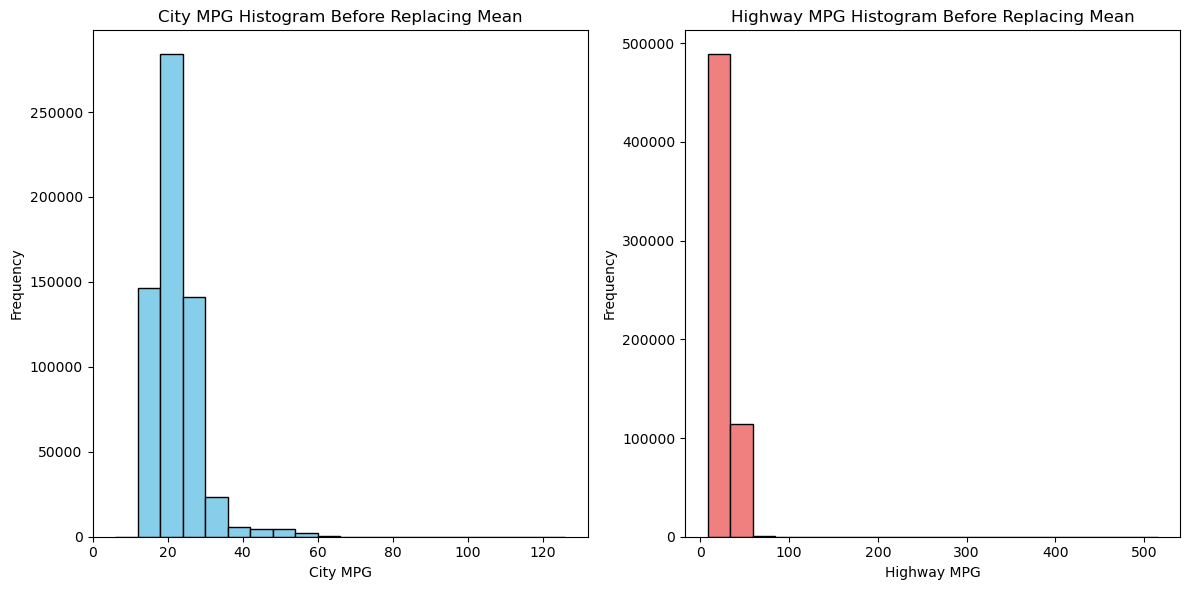

In [16]:
def Create_MPG_histograms(df, str):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df['City MPG'], bins=20, color='skyblue', edgecolor='black')
    plt.title('City MPG Histogram '+str+' Replacing Mean')
    plt.xlabel('City MPG')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(df['Highway MPG'], bins=20, color='lightcoral', edgecolor='black')
    plt.title('Highway MPG Histogram '+str+' Replacing Mean')
    plt.xlabel('Highway MPG')
    plt.ylabel('Frequency')

    plt.tight_layout()

    # Show the histograms
    plt.show()
    
Create_MPG_histograms(df, 'Before')

* **Replace `NAN` in '`City MPG`' and '`Highway MPG`' by the `Mean` of each column**

In [17]:
df['City MPG'] .replace(np.nan,df['City MPG'].mean(), inplace=True)
df['Highway MPG'].replace(np.nan,df['Highway MPG'].mean(), inplace=True)

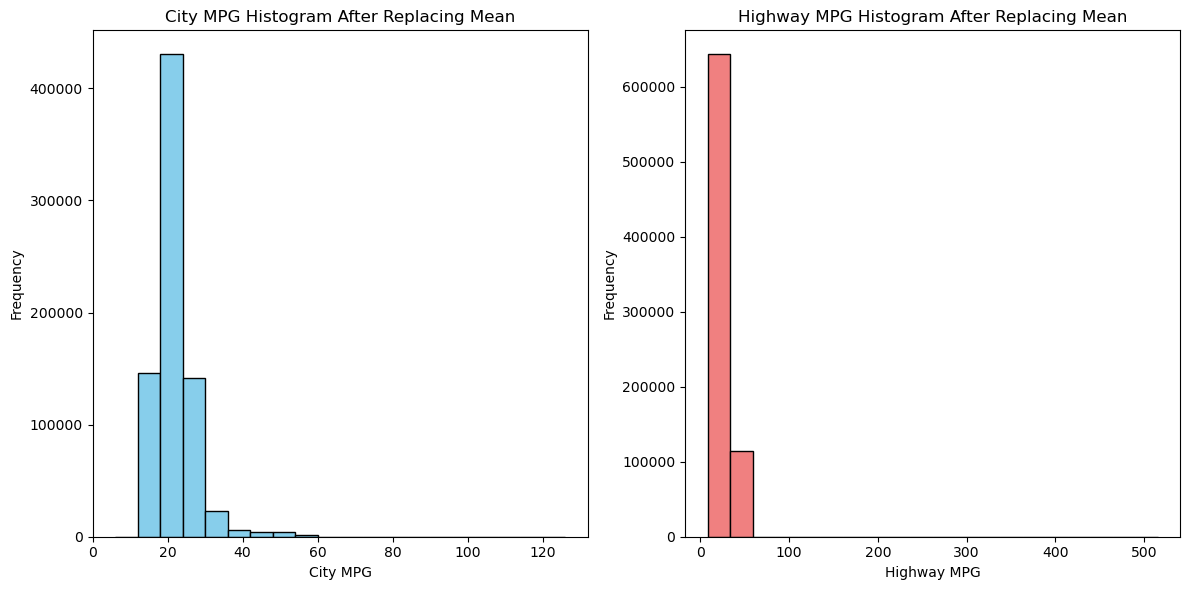

In [18]:
Create_MPG_histograms(df, 'After')

In [21]:
df= df.drop('price_drop', axis=1)
df.dropna()

,manufacturer,model,year,mileage,transmission,drivetrain,fuel_type,exterior_color,interior_color,accidents_or_damage,...,seller_name,seller_rating,driver_rating,driver_reviews_num,price,Engine Displacement (L),Engine Type,Engine Features,City MPG,Highway MPG
2,Acura,Integra A-Spec,2023,6.0,Automatic CVT,FWD,Gasoline,Red,Ebony,0.0,...,Glenview Luxury Imports,4.9,4.6,5,37434,1.5,I4,16V GDI DOHC Turbo,29.00000,36.000000
3,Acura,Integra A-Spec Technology,2023,9705.0,Automatic CVT,FWD,Gasoline,Platinum White Pearl,Ebony,0.0,...,Lindsay Acura,3.6,4.6,5,34516,1.5,I4,16V GDI DOHC Turbo,29.00000,36.000000
6,Acura,Integra A-Spec Technology,2023,10805.0,6-Speed Manual,FWD,Gasoline,Gray,Ebony,0.0,...,Honda of Keene,4.5,4.6,5,37500,1.5,I4,16V GDI DOHC Turbo,26.00000,36.000000
7,Acura,Integra A-Spec,2023,6612.0,Automatic CVT,FWD,Gasoline,Apex Blue Pearl,Ebony,0.0,...,Audi Fort Myers,4.6,4.6,5,32995,1.5,I4,16V GDI DOHC Turbo,29.00000,36.000000
9,Acura,Integra A-Spec Technology,2023,75.0,Automatic CVT,FWD,Gasoline,Performance Red Pearl,Orchid,0.0,...,Lindsay Acura,3.6,4.6,5,34662,1.5,I4,16V GDI DOHC Turbo,29.00000,36.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758008,Porsche,911 Carrera Cabriolet,1995,54400.0,6-Speed Manual,RWD,Gasoline,Red,Black,0.0,...,Porsche Delaware,4.5,4.7,16,127795,3.6,H6,MPFI SOHC,17.00000,25.000000
758009,Porsche,911 Carrera Cabriolet,1995,70603.0,6-Speed Manual,RWD,Gasoline,Black,Cashmere Beige,0.0,...,Auto By Design,4.6,4.7,16,73790,3.6,H6,MPFI SOHC,17.00000,25.000000
758017,Toyota,4Runner SR5 V6,1995,200331.0,5-Speed Manual,4WD,Gasoline,Dark Gray Metallic,Gray,0.0,...,Columbia Motors,2.9,4.2,8,9991,3.0,V6,SPFI SOHC,13.00000,16.000000
758020,Toyota,Corolla DX,1995,168722.0,5-Speed Manual,FWD,Gasoline,Wintergreen Metallic,Gray,1.0,...,Performance Toyota Bountiful,4.2,4.3,18,5000,1.8,I4,16V SPFI SOHC,28.00000,34.000000


* #### **Handling `NAN` in `seller_rating`**

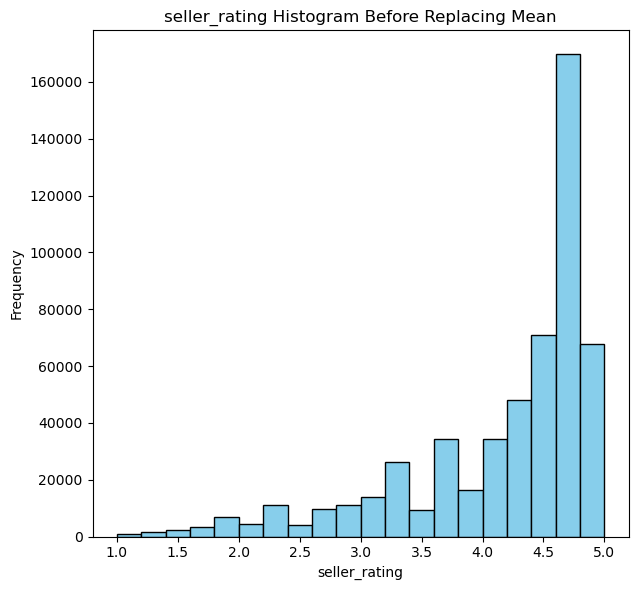

In [23]:

def Create_seller_rating_histograms(df, str):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df['seller_rating'], bins=20, color='skyblue', edgecolor='black')
    plt.title('seller_rating Histogram '+str+' Replacing Mean')
    plt.xlabel('seller_rating')
    plt.ylabel('Frequency')
    plt.tight_layout()

    # Show the histograms
    plt.show()
    
Create_seller_rating_histograms(df, 'Before')

In [24]:
df['seller_rating'].replace(np.nan,df['seller_rating'].mean(), inplace=True)

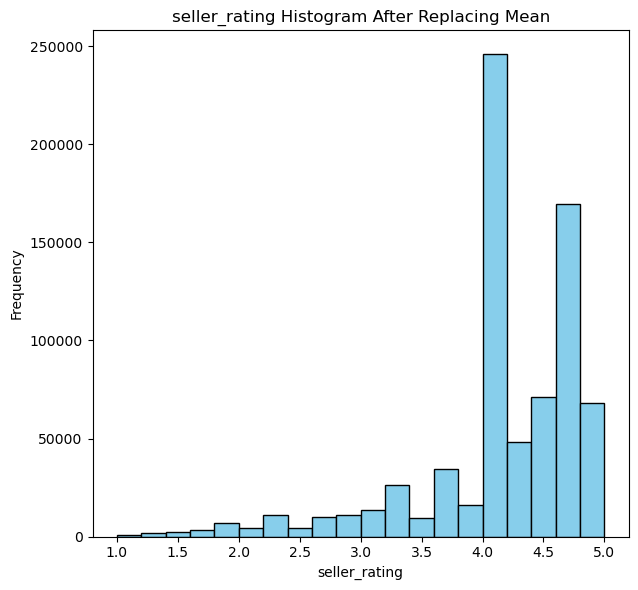

In [25]:
Create_seller_rating_histograms(df, 'After')

In [22]:
df.isnull().sum()

manufacturer                    0
model                           0
year                            0
mileage                       479
transmission                 9598
drivetrain                  19473
fuel_type                   21138
exterior_color               8708
interior_color              56369
accidents_or_damage         24089
one_owner                   29355
personal_use_only           24195
seller_name                  8538
seller_rating              211417
driver_rating               29889
driver_reviews_num              0
price                           0
Engine Displacement (L)    116417
Engine Type                116417
Engine Features            116417
City MPG                        0
Highway MPG                     0
dtype: int64

In [ ]:
# Load your dataset (replace 'your_data.csv' with your actual file)

# Use value_counts to count the frequency of each Engine Type
engine_type_counts = df['Engine Features'].value_counts()

# Get the top 20 values with the highest frequency
top_20_engine_types = engine_type_counts.head(40)

# Print the top 20 values and their frequencies
print(top_20_engine_types)

In [ ]:
df.isnull().sum()

In [ ]:
filtered_data.shape

#after handling data

In [ ]:
for feature in df.columns.tolist():
    print(f"{df[feature].value_counts()}, \n")

In [ ]:
df

In [ ]:
df.info() #shows a summary of our dataset

* Check and drop **Null** values

In [ ]:
df.isnull().sum()

There is null value in **fuel_consumption_g_km** column. So, we need to drop these before using it

In [ ]:
#df=df.dropna().reset_index(drop=True)

* Check and drop duplicates:

In [ ]:
df=df.drop_duplicates()

The data set after cleaning up

In [ ]:
df

* Counting the data for each feature:

In [ ]:
for feature in df.columns.tolist():
    print(f"{df[feature].value_counts()}, \n")

We can observe the presence of outliers, and the data spans a wide range.

<a id="6"></a>
<font color = 'blue'> 
## **6. Exploratory Data Analysis (EDA)**

## **Dectecting outliers**
* ### **For numerical columns**

Getting numerical columns

In [ ]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
#numerical_cols.remove('Senior Citizen')
num_columns=df[numerical_cols]

* Mean Car Price by year with outliers

<div class="alert alert-block alert-warning">
<b>Note:</b>  This method is just applied for <b>numerical features</b>. <br>
There is no specific way to detect outlier for <b>categorical columns</b>. We can plot the Frequency vs Price for each categorical columns, and then decide the outliers depend on the frequency.
</div>


In [ ]:

mean_prices_by_year = df.groupby('year')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price'], marker='o', linestyle='-')
plt.title('Mean Car Price by year (before removed outliers)')
plt.xlabel('year')
plt.ylabel('Mean Price')
plt.grid(True)
plt.show()

In [ ]:


Q1 = num_columns[numerical_cols].quantile(0.25)
Q3 = num_columns[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers and create a boolean mask
outliers_mask = (num_columns[numerical_cols] < lower_bound) | (num_columns[numerical_cols] > upper_bound)

# Drop the rows containing outliers
num_columns = num_columns[~outliers_mask]

In [ ]:
numerical_cols

This is new numerical columns after removed the outliers

In [ ]:
new_num_columns= num_columns.dropna() #drop the rows which are contain NAN 
new_num_columns

* Plot Average Price vs Years ((after removed outliers))


In [ ]:

mean_prices_by_year = new_num_columns.groupby('year')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price'], marker='o', linestyle='-')
plt.title('Mean Car Price by year (after removed outliers)')
plt.xlabel('year')
plt.ylabel('Mean Price')
plt.grid(True)
plt.show()

In [ ]:
# Convert 'mileage_in_km' column to numeric if it's not already
new_num_columns['mileage'] = pd.to_numeric(new_num_columns['mileage'], errors='coerce')

# Define the number of bins and calculate the range based on the data
num_bins = 16
min_range = 0
max_range = new_num_columns['mileage'].max()

# Create labels with custom ranges
bin_size = round((max_range - min_range) / num_bins,-3)
labels = [f'{int(min_range + i * bin_size)}-{int(min_range + (i + 1) * bin_size)}' for i in range(num_bins)]

# Using pd.cut, divide the 'mileage_in_km' column into bins with labels
new_num_columns['mileage_ranges'] = pd.cut(new_num_columns['mileage'], bins=num_bins, labels=labels, include_lowest=True)


# Create the bar plot
fig, ax = plt.subplots()
value_counts = new_num_columns['mileage_ranges'].value_counts()
value_counts[labels].plot(ax=ax, kind='barh', ylabel='Mileage Ranges', xlabel='Frequency')
plt.show()

* ### **For categorical columns:**
We need to plot them vs Price to see the pattern

In [ ]:
cat_columns= df.select_dtypes(include=['object']).columns.tolist()
 #these are the columns that wee need to plot se dectect the outliers

In [ ]:

# Create a figure with multiple subplots
fig = plt.figure(figsize=(10, 5 * len(cat_columns)))
for i, cat_feature in enumerate(cat_columns):
    ax = fig.add_subplot(len(cat_columns), 1, i + 1)
    df[cat_feature].value_counts().plot(ax=ax, kind='bar', xlabel=cat_feature, ylabel='Frequency')
    ax.set_title(cat_feature)

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-warning">
<b>Discussion:</b>  `Based on these plots for categorical features, we can decide how much data we can remove`
</div>

Let's drop these classes from categorical columns:<br>

* `Unknow`, `Semi-automatic` from `transmission_type` column<br>
* `LPG`, `CNG`, `Diesel Hybrid`, `Hydrogen`, `Electric`, `Ethanol` from `fuel_type` columns

### **!!! We can drop more class if we needed**

In [ ]:
df = df.loc[~df['fuel_type'].isin(['LPG', 'CNG', 'Diesel Hybrid', 'Hydrogen', 'Electric', 'Ethanol'])]
df = df.loc[~df['transmission_type'].isin(['Unknown', 'Semi-automatic'])]
#reset the index
df.reset_index(drop=True)

In [ ]:
'''data= pd.concat([new_num_columns , cat_columns, Y], axis=1)
data = data.dropna().reset_index(drop=True)
data.info()'''